In [53]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special
import jax
import duckdb

import imprint as ip
import confirm
import confirm.adagrid as ada
from confirm.adagrid.const import MAX_STEP
import confirm.cloud.clickhouse as ch

ip.setup_nb()

db = "wd41_4d_20230402_132502"

ddb_path = Path(confirm.__file__).parent.parent.joinpath(f"{db}.db")
use_clickhouse = False
if ddb_path.exists():
    try:
        ddb = ada.DuckDBTiles(duckdb.connect(str(ddb_path), read_only=True))

        def query(q):
            return ddb.con.query(q).df()

    except Exception:
        use_clickhouse = True
else:
    use_clickhouse = True

if use_clickhouse:
    ch_db = ch.ClickhouseTiles.connect(db, service="PROD")
    query = ch_db.query


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-04-02 13:29:09,135 - imprint - DEBUG 
Enabling 64-bit floats in JAX.
2023-04-02 13:29:09,135 - confirm.cloud.clickhouse - INFO 
Clickhouse config: default@retpwkzwje.us-east-1.aws.clickhouse.cloud:8443/None
2023-04-02 13:29:09,275 - confirm.cloud.clickhouse - DEBUG 
Command took 0.020033836364746094 seconds
create database if not exists wd41_4d_20230402_132502
2023-04-02 13:29:09,275 - confirm.cloud.clickhouse - INFO 
Connected to job wd41_4d_20230402_132502


In [54]:
dim = len(
    [c for c in query("select * from results limit 1").columns if c.startswith("theta")]
)
n_steps = query("select max(step_id) from results").iloc[0][0] + 1
dim, n_steps


2023-04-02 13:29:10,149 - confirm.cloud.clickhouse - DEBUG 
Query took 0.09208083152770996 seconds
select * from results limit 1
2023-04-02 13:29:10,209 - confirm.cloud.clickhouse - DEBUG 
Query took 0.05941486358642578 seconds
select max(step_id) from results


(4, 8)

## Broad table exploration


In [4]:
n_rows_df = pd.DataFrame(
    [
        (table, query(f"select count(*) from {table}").iloc[0][0])
        for table in ch.all_tables
    ],
    columns=["table", "count"],
).set_index("table")
n_rows_df


2023-04-02 10:36:44,135 - confirm.cloud.clickhouse - DEBUG 
Query took 0.06836795806884766 seconds
select count(*) from results
2023-04-02 10:36:44,162 - confirm.cloud.clickhouse - DEBUG 
Query took 0.02575993537902832 seconds
select count(*) from tiles
2023-04-02 10:36:44,202 - confirm.cloud.clickhouse - DEBUG 
Query took 0.038626670837402344 seconds
select count(*) from done
2023-04-02 10:36:44,223 - confirm.cloud.clickhouse - DEBUG 
Query took 0.02024388313293457 seconds
select count(*) from config
2023-04-02 10:36:44,241 - confirm.cloud.clickhouse - DEBUG 
Query took 0.01830911636352539 seconds
select count(*) from logs
2023-04-02 10:36:44,264 - confirm.cloud.clickhouse - DEBUG 
Query took 0.022297143936157227 seconds
select count(*) from reports
2023-04-02 10:36:44,299 - confirm.cloud.clickhouse - DEBUG 
Query took 0.03430986404418945 seconds
select count(*) from null_hypos


,count
table,
results,182230
tiles,266558
done,96821
config,1
logs,108
reports,4
null_hypos,2


In [35]:
from confirm.adagrid.const import MAX_STEP

n_sims = query("select sum(K) from results").iloc[0][0]
n_retained_sims = query(
    f"select sum(K) from results where inactivation_step={MAX_STEP} and id not in (select id from done where active=false)"
).iloc[0][0]
n_sims / 1e12, n_retained_sims / 1e12


2023-03-31 18:17:43,144 - confirm.cloud.clickhouse - DEBUG 
Query took 0.7327299118041992 seconds
select sum(K) from results
2023-03-31 18:17:44,571 - confirm.cloud.clickhouse - DEBUG 
Query took 1.4261419773101807 seconds
select sum(K) from results where inactivation_step=4294967295 and id not in (select id from done where active=false)


(0.054820593664, 0.052061986816)

In [12]:
n_active_tiles = query(
    f"select count(*) from results where inactivation_step={MAX_STEP}"
).iloc[0][0]
n_eligible_tiles = query(
    f"select count(*) from results where completion_step={MAX_STEP}"
).iloc[0][0]
n_active_tiles, n_eligible_tiles


(9047342, 9047342)

In [13]:
query(
    f"select K, count(*) as n_tiles from tiles where inactivation_step={MAX_STEP} group by K order by K"
)


,K,n_tiles
0,8192,9047342


In [14]:
volume_sql = str(2**dim) + "*" + ("*".join([f"radii{d}" for d in range(dim)]))


In [15]:
smallest_tile = query(
    f"select * from results where inactivation_step={MAX_STEP} order by {volume_sql} limit 1"
)
smallest_tile


,id,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,inactivation_step,orderer,idx,alpha0,impossible,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,B_lams20,B_lams21,B_lams22,B_lams23,B_lams24,B_lams25,B_lams26,B_lams27,B_lams28,B_lams29,B_lams30,B_lams31,B_lams32,B_lams33,B_lams34,B_lams35,B_lams36,B_lams37,B_lams38,B_lams39,B_lams40,B_lams41,B_lams42,B_lams43,B_lams44,B_lams45,B_lams46,B_lams47,B_lams48,B_lams49,completion_step
0,7216444109899956816,7216444088425363824,-1.278125,-1.278125,-1.540625,-1.465625,0.009375,0.009375,0.009375,0.009375,True,False,8192,8,100,4294967295,0.018769,165,0.020362,False,0.023907,0.022191,0.018769,0.022446,0.02096,0.021841,0.022981,0.02189,0.024064,0.021409,0.023852,0.019823,0.022981,0.023344,0.021841,0.019471,0.021409,0.023852,0.021841,0.021179,0.020103,0.021959,0.019309,0.024023,0.023134,0.021409,0.023773,0.021764,0.019823,0.020301,0.024524,0.019823,0.021469,0.024872,0.022446,0.023134,0.021841,0.021409,0.023852,0.021469,0.023907,0.019823,0.021841,0.020103,0.022446,0.02309,0.023134,0.022983,0.023653,0.02288,0.023784,0.02309,0.023907,0.02323,4294967295


In [16]:
largest_tile = query(
    f"select * from results where inactivation_step={MAX_STEP} order by {volume_sql} desc limit 1"
)
largest_tile


,id,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,inactivation_step,orderer,idx,alpha0,impossible,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,B_lams20,B_lams21,B_lams22,B_lams23,B_lams24,B_lams25,B_lams26,B_lams27,B_lams28,B_lams29,B_lams30,B_lams31,B_lams32,B_lams33,B_lams34,B_lams35,B_lams36,B_lams37,B_lams38,B_lams39,B_lams40,B_lams41,B_lams42,B_lams43,B_lams44,B_lams45,B_lams46,B_lams47,B_lams48,B_lams49,completion_step
0,7216443418409613232,7216443409819852304,-1.2125,-1.2125,-1.8125,-1.3625,0.0375,0.0375,0.0375,0.0375,True,False,8192,3,76,4294967295,0.009171,85,0.010568,False,0.01327,0.01098,0.009171,0.010991,0.01026,0.010991,0.010991,0.011029,0.011754,0.010195,0.011548,0.008472,0.010991,0.011754,0.011155,0.009379,0.009379,0.011548,0.011054,0.010195,0.010122,0.010456,0.008853,0.01327,0.011029,0.009923,0.011054,0.011548,0.010195,0.009923,0.012576,0.011155,0.011548,0.011754,0.010928,0.012407,0.011054,0.011054,0.011054,0.009171,0.011548,0.009946,0.010991,0.010122,0.010928,0.010404,0.012188,0.012282,0.01026,0.011155,0.012169,0.011054,0.01327,0.010122,4294967295


In [17]:
n_possible_tiles = query("select count(*) from results where isNotNull(lams)").iloc[0][
    0
]
n_possible_tiles


CatalogException: Catalog Error: Scalar Function with name isnotnull does not exist!
Did you mean "isnan"?

In [18]:
lamss_tile = query(
    f"""
select * from results 
    where inactivation_step={MAX_STEP} 
        and isNotNull(lams) 
    order by lams 
    limit 1
"""
)
lamss_tile


CatalogException: Catalog Error: Scalar Function with name isnotnull does not exist!
Did you mean "isnan"?

In [19]:
lamss = lamss_tile["lams"].iloc[0]


NameError: name 'lamss_tile' is not defined

2023-03-30 15:27:09,001 - confirm.cloud.clickhouse - DEBUG 
Query took 0.038573265075683594 seconds

select lams from results 
    where inactivation_step=4294967295 
        and lams <= nan



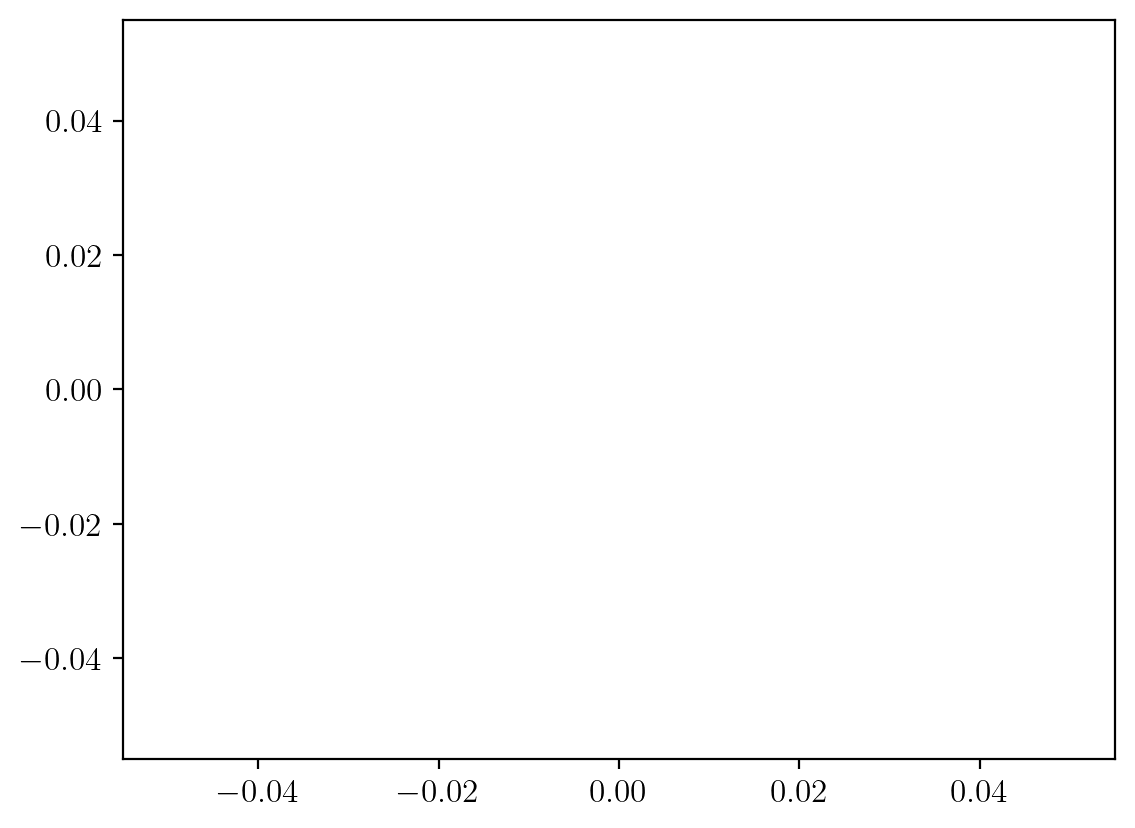

In [115]:
lams = query(
    f"""
select lams from results 
    where inactivation_step={MAX_STEP} 
        and lams <= {lamss}
"""
)
max_display = lamss * 2
plt.hist(lams["lams"], bins=np.linspace(lamss, max_display, 100))
plt.show()


## Ordering


In [21]:
worst5000_df = self.con.query(
    "select * from results where inactivation_step>10000 order by lams limit 5000"
).df()


In [22]:
orderer_df = self.con.query(
    f"select orderer from results where inactivation_step>10000 and orderer <= {worst5000_df['orderer'].max()} order by orderer"
).df()


In [23]:
wait = np.searchsorted(orderer_df["orderer"], worst5000_df["orderer"])
wait


array([     0,      0,      0,      0,      0,      0,      0,      0,      0,     45, ..., 151702,
       151702, 151702,  63950,  63950,  63950,  63950,  63950,  63950,  95159])

In [15]:
cfg = self.get_config().iloc[0].to_dict()


In [47]:
import confirm.adagrid.calibrate as adacal
import confirm.models.wd41 as wd41

report = dict()
algo = adacal.AdaCalibrate(
    wd41.WD41(0, 600000, ignore_intersection=True), None, self, cfg, None
)


In [48]:
tiles_df = self.next(10, 11, 50000, "orderer")
twb_worst_tile = self.worst_tile(10, "twb_mean_lams")
# np.sum(tiles_df['twb_min_lams'] > twb_worst_tile['twb_mean_lams'].iloc[0])


In [51]:
self = algo
twb_worst_tile = self.db.worst_tile(10, "twb_mean_lams")
for col in twb_worst_tile.columns:
    if col.startswith("radii"):
        twb_worst_tile[col] = 1e-6
twb_worst_tile["K"] = self.max_K
twb_worst_tile_lams = self.driver.bootstrap_calibrate(
    twb_worst_tile,
    self.cfg["alpha"],
    calibration_min_idx=self.cfg["calibration_min_idx"],
    tile_batch_size=1,
)
twb_worst_tile_mean_lams = twb_worst_tile_lams["twb_mean_lams"].iloc[0]
deepen_likely_to_work = tiles_df["twb_min_lams"] > twb_worst_tile_mean_lams


In [53]:
np.sum(deepen_likely_to_work)


0

## Looking at the reports


In [55]:
import json

reports = [json.loads(v) for v in query("select * from reports")["json"].values]
report_df = pd.DataFrame(reports)
working_reports = report_df[report_df["status"] == "WORKING"].dropna(axis=1, how="all")
new_step_reports = report_df[report_df["status"] == "NEW_STEP"].dropna(
    axis=1, how="all"
)
new_step_reports.set_index("step_id", inplace=True)


2023-04-02 13:29:14,058 - confirm.cloud.clickhouse - DEBUG 
Query took 0.17986702919006348 seconds
select * from reports


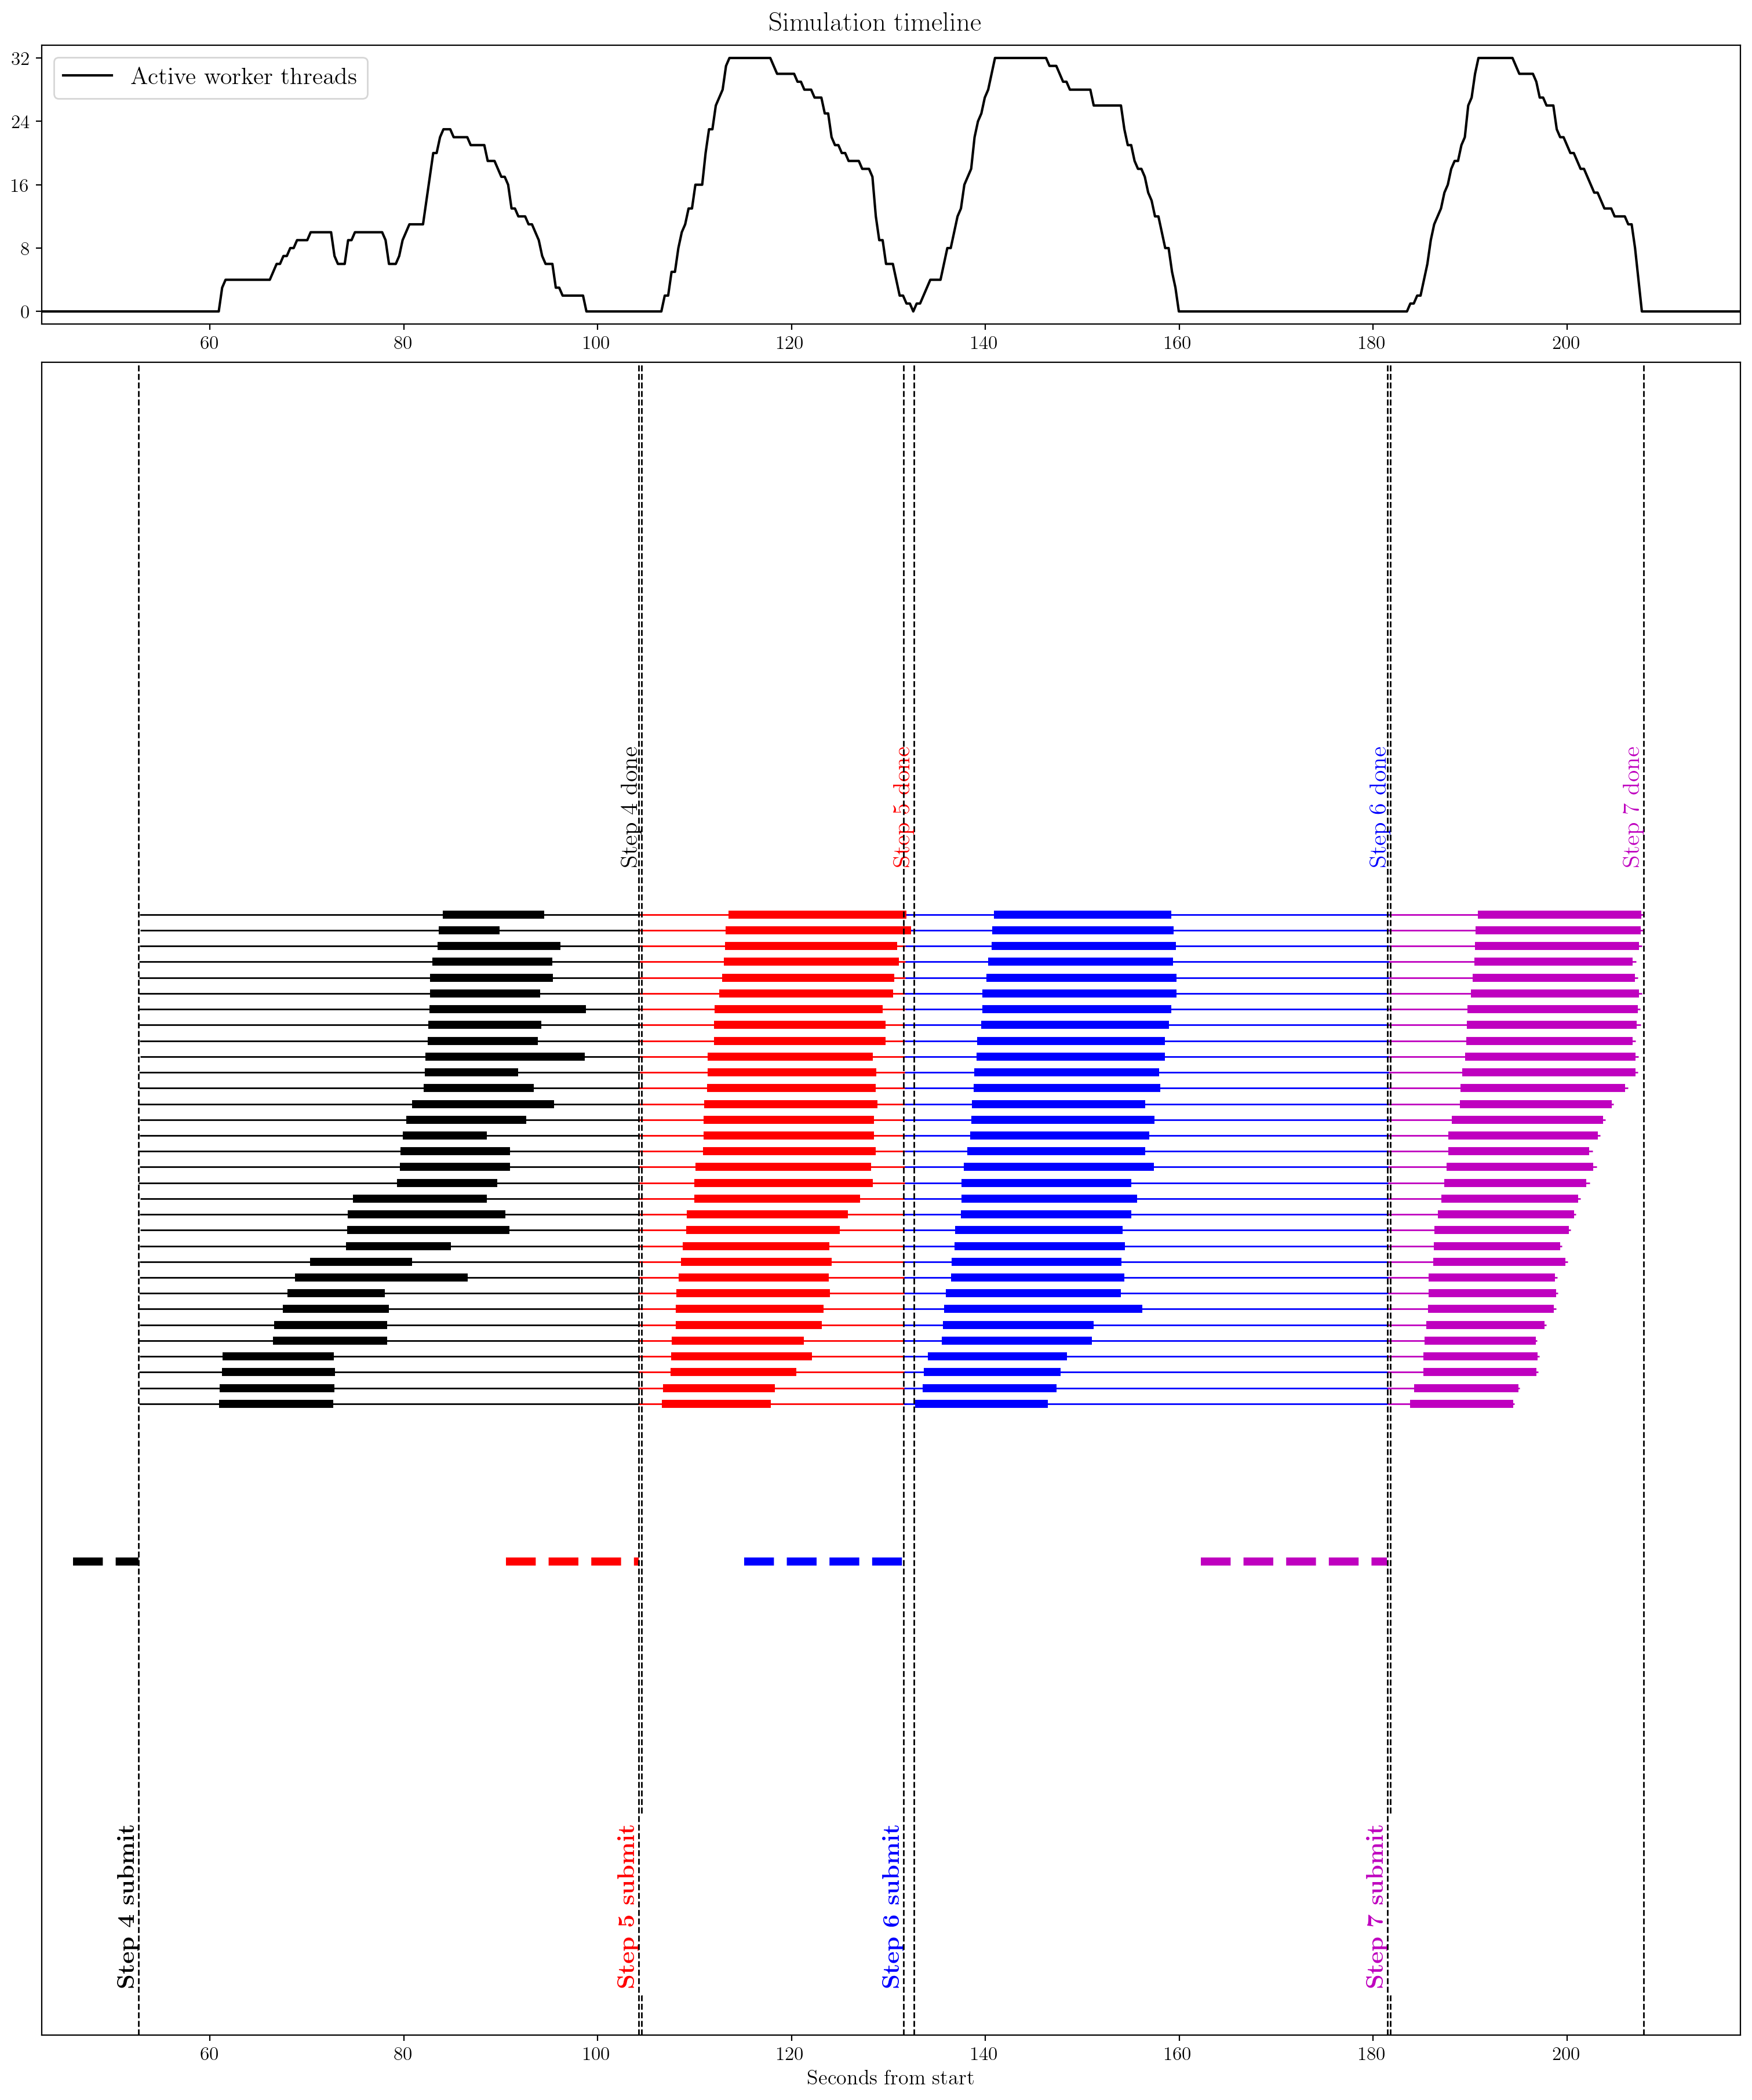

In [57]:
from matplotlib.gridspec import GridSpec

min_step = 4
max_step = 10
color_list = ["k", "r", "b", "m"]
offset = report_df["start_time"].min()

step_id = working_reports["step_id"]
include = (step_id >= min_step) & (step_id <= max_step)
df = working_reports[include][
    ["sim_start_time", "sim_done_time", "start_time", "done_time", "step_id"]
].copy()
df.sort_values(by=["sim_start_time"], inplace=True)
df["adjusted_start_time"] = df["start_time"] - offset
df["adjusted_done_time"] = df["done_time"] - offset
df["adjusted_sim_start_time"] = df["sim_start_time"] - offset
df["adjusted_sim_done_time"] = df["sim_done_time"] - offset
min_time = df["adjusted_start_time"].min() - 10
max_time = df["adjusted_done_time"].max() + 10

df["positions"] = (df.groupby("step_id").cumcount()) / 10.0
df["packet_linelengths"] = df["done_time"] - df["start_time"]
df["packet_lineoffsets"] = df["adjusted_start_time"] + df["packet_linelengths"] * 0.5
df["packet_linewidths"] = 1

df["positions"] = (df.groupby("step_id").cumcount()) / 10.0
df["linelengths"] = df["sim_done_time"] - df["sim_start_time"]
df["lineoffsets"] = (
    df["sim_start_time"] - report_df["start_time"].min() + df["linelengths"] * 0.5
)
df["colors"] = np.array(color_list)[df["step_id"] % len(color_list)]
df["linewidths"] = 5
fig = plt.figure(figsize=(15, 18), constrained_layout=True)
plt.suptitle("Simulation timeline")
gs = GridSpec(7, 1, figure=fig)
plt.subplot(gs[0, 0])
ts = np.linspace(min_time, max_time, 500)
ongoing = []
for t in ts:
    ongoing.append(
        ((df["adjusted_sim_start_time"] < t) & (df["adjusted_sim_done_time"] > t)).sum()
    )
plt.plot(ts, ongoing, "k-", label="Active worker threads")
plt.legend()
plt.xlim([min_time, max_time])
plt.yticks(np.arange(0, 33, 8))

plt.subplot(gs[1:, 0])
plt.eventplot(
    df["positions"].values[:, None],
    lineoffsets="packet_lineoffsets",
    linelengths="packet_linelengths",
    linewidths="packet_linewidths",
    colors="colors",
    orientation="vertical",
    data=df,
)
plt.eventplot(
    df["positions"].values[:, None],
    lineoffsets="lineoffsets",
    linelengths="linelengths",
    linewidths="linewidths",
    colors="colors",
    orientation="vertical",
    data=df,
)

new_step_reports["adjusted_step_start_time"] = (
    new_step_reports["time"] - new_step_reports["runtime_total"] - offset
)
new_step_reports["adjusted_step_done_time"] = new_step_reports["time"] - offset
for step_id in range(min_step, max_step + 1):
    try:
        rpt = new_step_reports.loc[step_id]
    except KeyError:
        continue
    plt.plot(
        [
            rpt["adjusted_step_start_time"],
            rpt["adjusted_step_done_time"],
        ],
        [-1, -1],
        color_list[step_id % len(color_list)],
        linestyle="--",
        linewidth=5,
    )

for step_id, step_df in df.groupby("step_id"):
    plt.axvline(
        step_df["adjusted_start_time"].min(),
        color="k",
        linestyle="--",
        linewidth=1,
        zorder=100,
    )
    plt.axvline(
        step_df["adjusted_done_time"].max(), color="k", linestyle="--", linewidth=1
    )
for step_id, step_df in df.groupby("step_id"):
    plt.text(
        step_df["adjusted_start_time"].min(),
        -3.7,
        "$\\textbf{Step " + str(step_id) + " submit}$",
        rotation=90,
        va="bottom",
        ha="right",
        color=color_list[step_id % len(color_list)],
        bbox=dict(facecolor="w", edgecolor="w", boxstyle="round"),
    )
    plt.text(
        step_df["adjusted_done_time"].max(),
        df["positions"].max() + 0.3,
        f"Step {step_id} done",
        rotation=90,
        va="bottom",
        ha="right",
        color=color_list[step_id % len(color_list)],
    )
plt.xlabel("Seconds from start")
plt.xlim([min_time, max_time])
plt.ylim([-4, df["positions"].max() + 3.5])
plt.gca().get_yaxis().set_visible(False)

plt.show()


In [65]:
sim_runtime = working_reports["runtime_simulating"].sum()
total_runtime = 2 * (report_df["done_time"].max() - report_df["start_time"].min())
parallelism = sim_runtime / total_runtime
parallelism, sim_runtime / 3600, total_runtime / 3600


(5.19824542839097, 0.6414676470226711, 0.12340080049302843)

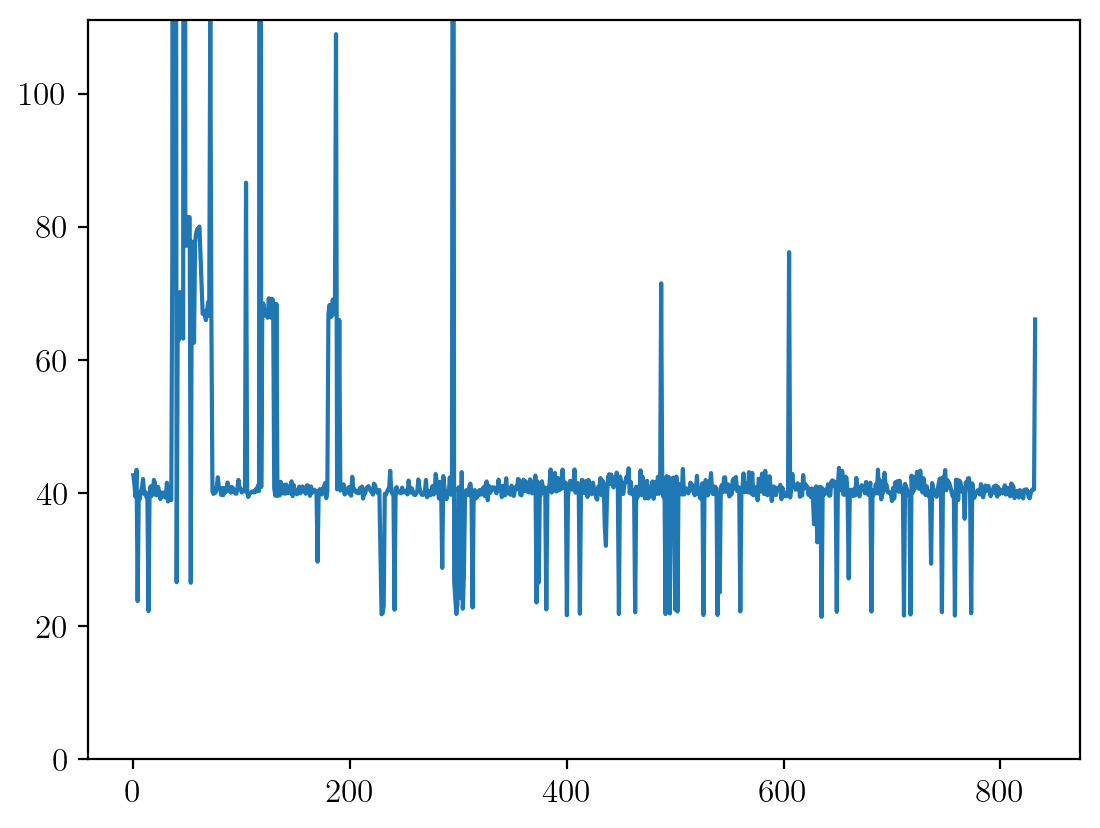

In [60]:
plt.plot(working_reports["runtime_per_sim_ns"])
plt.ylim([0, np.percentile(working_reports["runtime_per_sim_ns"], 99.5)])
plt.show()


In [62]:
working_reports["runtime_simulating"].sum()


2309.283529281616

In [64]:
max_working_time = working_reports.groupby("step_id")["time"].max()
total_sim_time = working_reports.groupby("step_id")["runtime_simulating"].sum()
ex_df = new_step_reports[["step_id", "runtime_total", "done_time"]].set_index("step_id")
ex_df["max_working_time"] = max_working_time
ex_df["total_sim_time"] = total_sim_time
step_parallelism = ex_df["total_sim_time"] / (
    (ex_df["max_working_time"] - ex_df["time"]) + ex_df["runtime_total"]
)
plt.plot(step_parallelism, "k-o", markersize=3)
plt.xlabel("step_id")
plt.ylabel("parallelism")
plt.show()


KeyError: 'Column not found: time'

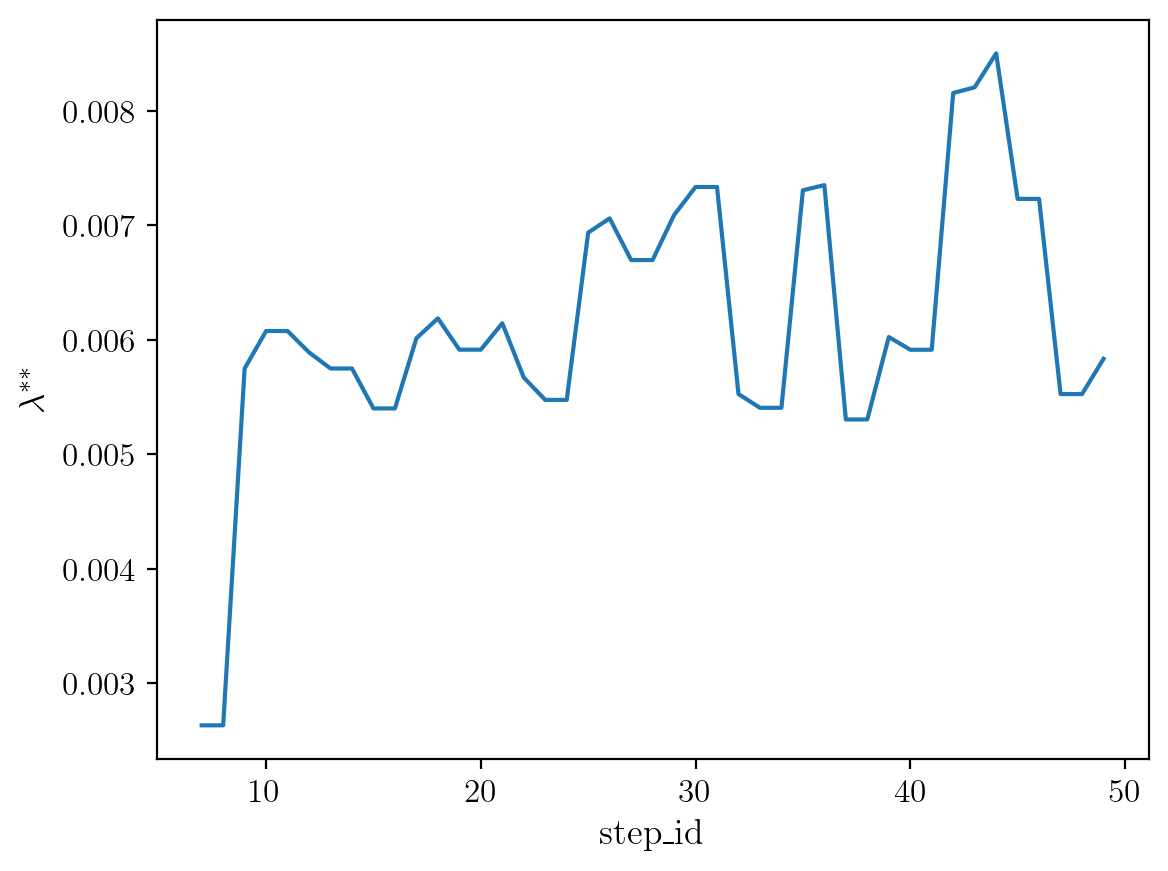

In [16]:
plt.plot(new_step_reports[["step_id", "lamss"]].set_index("step_id"))
plt.xlabel("step_id")
plt.ylabel("$\lambda^{**}$")
plt.show()


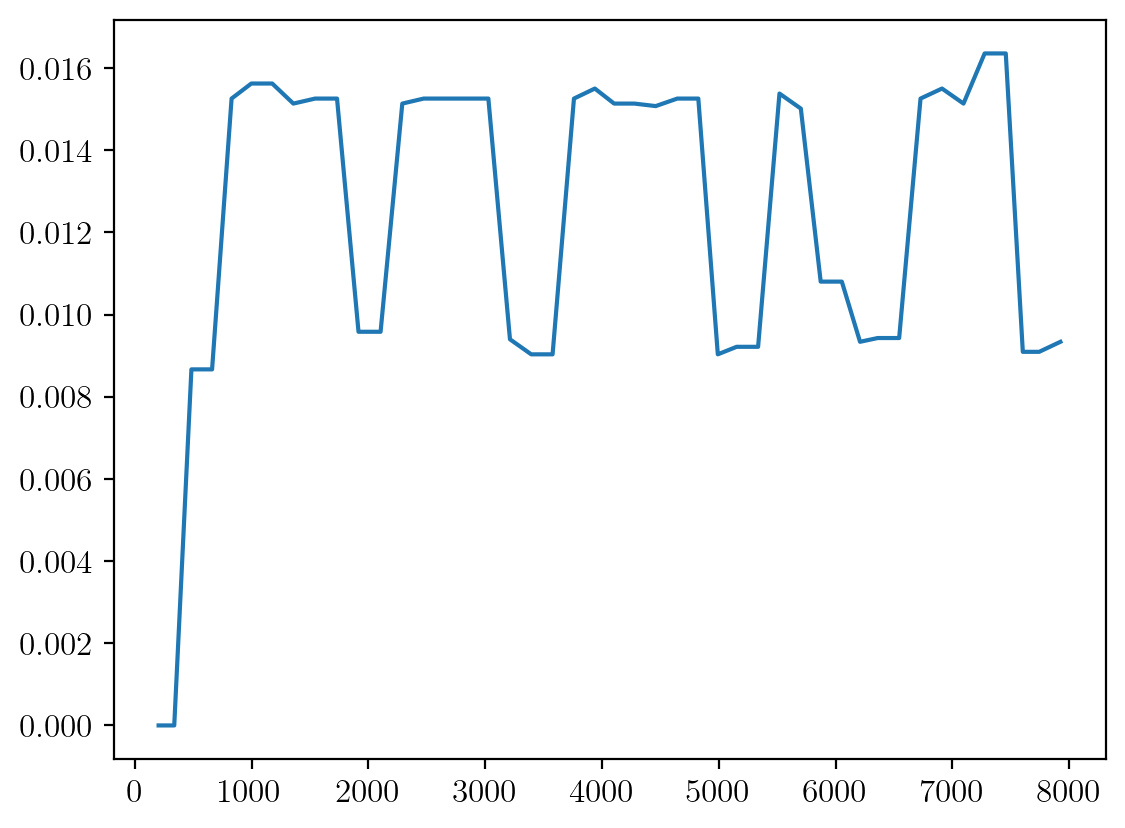

In [17]:
plt.plot(new_step_reports["tie_{k}(lamss)"])
plt.show()


In [19]:
import numpy as np

xs = np.linspace(-2, 1, 10)
ys = np.linspace(-2, 1, 10)
counts = np.empty((len(xs), len(ys)))
for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        NN = self.con.query(
            f"""
            select count(*) 
                from results
                where 
                    inactivation_step={MAX_STEP}
                    and abs(theta0 - {x}) < 0.167
                    and abs(theta2 - {y}) < 0.167
        """
        ).fetchone()[0]
        counts[i, j] = NN


In [20]:
counts.sum() / 1e6


61.254279

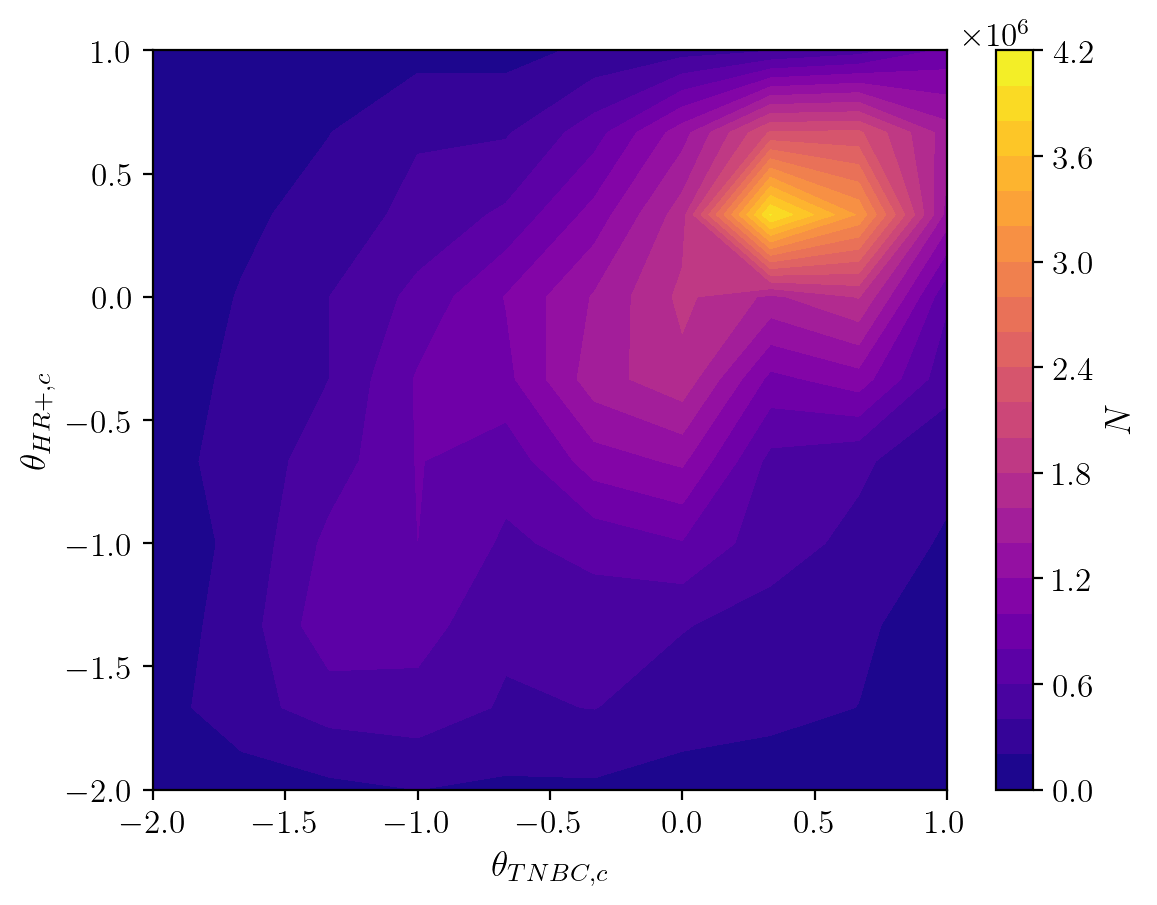

In [21]:
XX, YY = np.meshgrid(xs, ys, indexing="ij")
# plt.scatter(XX.ravel(), YY.ravel(), c=counts.ravel())
plt.contourf(XX, YY, counts, levels=20)
plt.xlabel("$\\theta_{TNBC, c}$")
plt.ylabel("$\\theta_{HR+, c}$")
cbar = plt.colorbar()
cbar.set_label("$N$")
plt.show()


In [22]:
plot_df = self.con.query(
    """
    select theta0, theta1, theta2, theta3, 
            radii0, radii1, radii2, radii3, 
            alpha0, K, lams, twb_mean_lams, twb_min_lams 
        from results
        where 
            abs(theta0 + 1) < 0.05
            and abs(theta2 + 1) < 0.05
"""
).df()


In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(plot_df["theta1"], plot_df["theta3"], c=plot_df["K"], s=5)
plt.colorbar()
plt.subplot(2, 2, 2)
plt.scatter(plot_df["theta1"], plot_df["theta3"], c=plot_df["alpha0"], s=5)
plt.colorbar()
plt.subplot(2, 2, 3)
plt.scatter(plot_df["theta1"], plot_df["theta3"], c=plot_df["lams"], s=5)
plt.colorbar()
plt.subplot(2, 2, 4)
plt.scatter(plot_df["theta1"], plot_df["theta3"], c=plot_df["twb_min_lams"], s=5)
plt.colorbar()
plt.show()
